In [4]:
# Matplotlib settings

import warnings
import matplotlib.pyplot as plt
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'font.weight': 'bold',      # Specify font weight                           ----------
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'axes.labelweight': 'bold',       # Axis label bold                         ----------
    'axes.titleweight': 'bold',     # Axis title bold                           ----------
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

In [1]:
# Imports
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import entropy

from SHAP_utils.shap_store import load_shap
from SHAP_utils.load_adult import load_adult_dataset

In [ ]:
# Functions

# PFI Importance

def process_importance(importance_result, feature_names, top_n=20):
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importance_result.importances_mean
    }).sort_values("importance_mean", ascending=False).head(top_n)

    sorted_feats = df["feature"].tolist()

    tidy_df = pd.DataFrame(
        importance_result.importances.T,
        columns=feature_names
    )[sorted_feats].melt(
        var_name="feature",
        value_name="importance"
    )

    return df, tidy_df, sorted_feats

# PFI Table

def print_pfi_table(importance_result, feature_names, model_name):
    df = pd.DataFrame({
        "feature": feature_names,
        "mean_roc_auc_decrease": importance_result.importances_mean
    }).sort_values("mean_roc_auc_decrease", ascending=False)
    
    print(f"\n{model_name} — Permutation Feature Importance (ROC-AUC)")
    print(df.to_string(index=False))

# Print SHAP Importace

def print_shap_importance(shap_values, feature_names, model_name):
    if isinstance(shap_values, shap.Explanation):
        values = shap_values.values
    else:
        values = shap_values

    mean_abs = np.abs(values).mean(axis=0)

    df = (
        pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\n{model_name} — SHAP Feature Importance (mean |SHAP|)")
    print(df)

# Iterative Feature Addition

def get_trajectory_data(ranking, mode, X_tr, y_tr, X_te, y_te):
    results = []

    if mode == "add_best":
        ordered = ranking
    elif mode == "add_worst":
        ordered = ranking[::-1]
    else:
        raise ValueError("Unsupported mode")

    for k in range(1, len(ordered) + 1):
        selected = ordered[:k]
        added_feature = ordered[k - 1]

        clf = xgb.XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        )

        clf.fit(X_tr[selected], y_tr)
        preds = clf.predict_proba(X_te[selected])[:, 1]
        score = roc_auc_score(y_te, preds)

        results.append({
            "Step": k,
            "Feature_Added": added_feature,
            "ROC_AUC": score
        })

    return pd.DataFrame(results)

def trajectory_to_xy(df):
    return df["Step"].values, df["ROC_AUC"].values

# NMI

def freedman_diaconis_bins(x):
    x = np.asarray(x).astype(float)

    x = x[~np.isnan(x)]
    if len(x) == 0: return 1
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    n = len(x)

    if iqr == 0: 
        return int(np.sqrt(n))

    bin_width = 2 * iqr / (n ** (1 / 3))
    if bin_width == 0:
        return int(np.sqrt(n))
        
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(2, bins)

def shannon_entropy(x, bins):
    x = x[~np.isnan(x)]
    hist, _ = np.histogram(x, bins=bins, density=False)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return entropy(prob, base=2)

def mutual_information(x, y, bins_x, bins_y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    joint_hist, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
    joint_prob = joint_hist / joint_hist.sum()

    px = joint_prob.sum(axis=1)
    py = joint_prob.sum(axis=0)

    mi = 0.0
    for i in range(joint_prob.shape[0]):
        for j in range(joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(
                    joint_prob[i, j] / (px[i] * py[j])
                )
    return mi

def normalized_mutual_information(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    bx = freedman_diaconis_bins(x)
    by = freedman_diaconis_bins(y)

    hx = shannon_entropy(x, bx)
    hy = shannon_entropy(y, by)
    mi = mutual_information(x, y, bx, by)
    
    denominator = np.sqrt(hx * hy)
    if denominator == 0: 
        return 0.0
    return mi / denominator

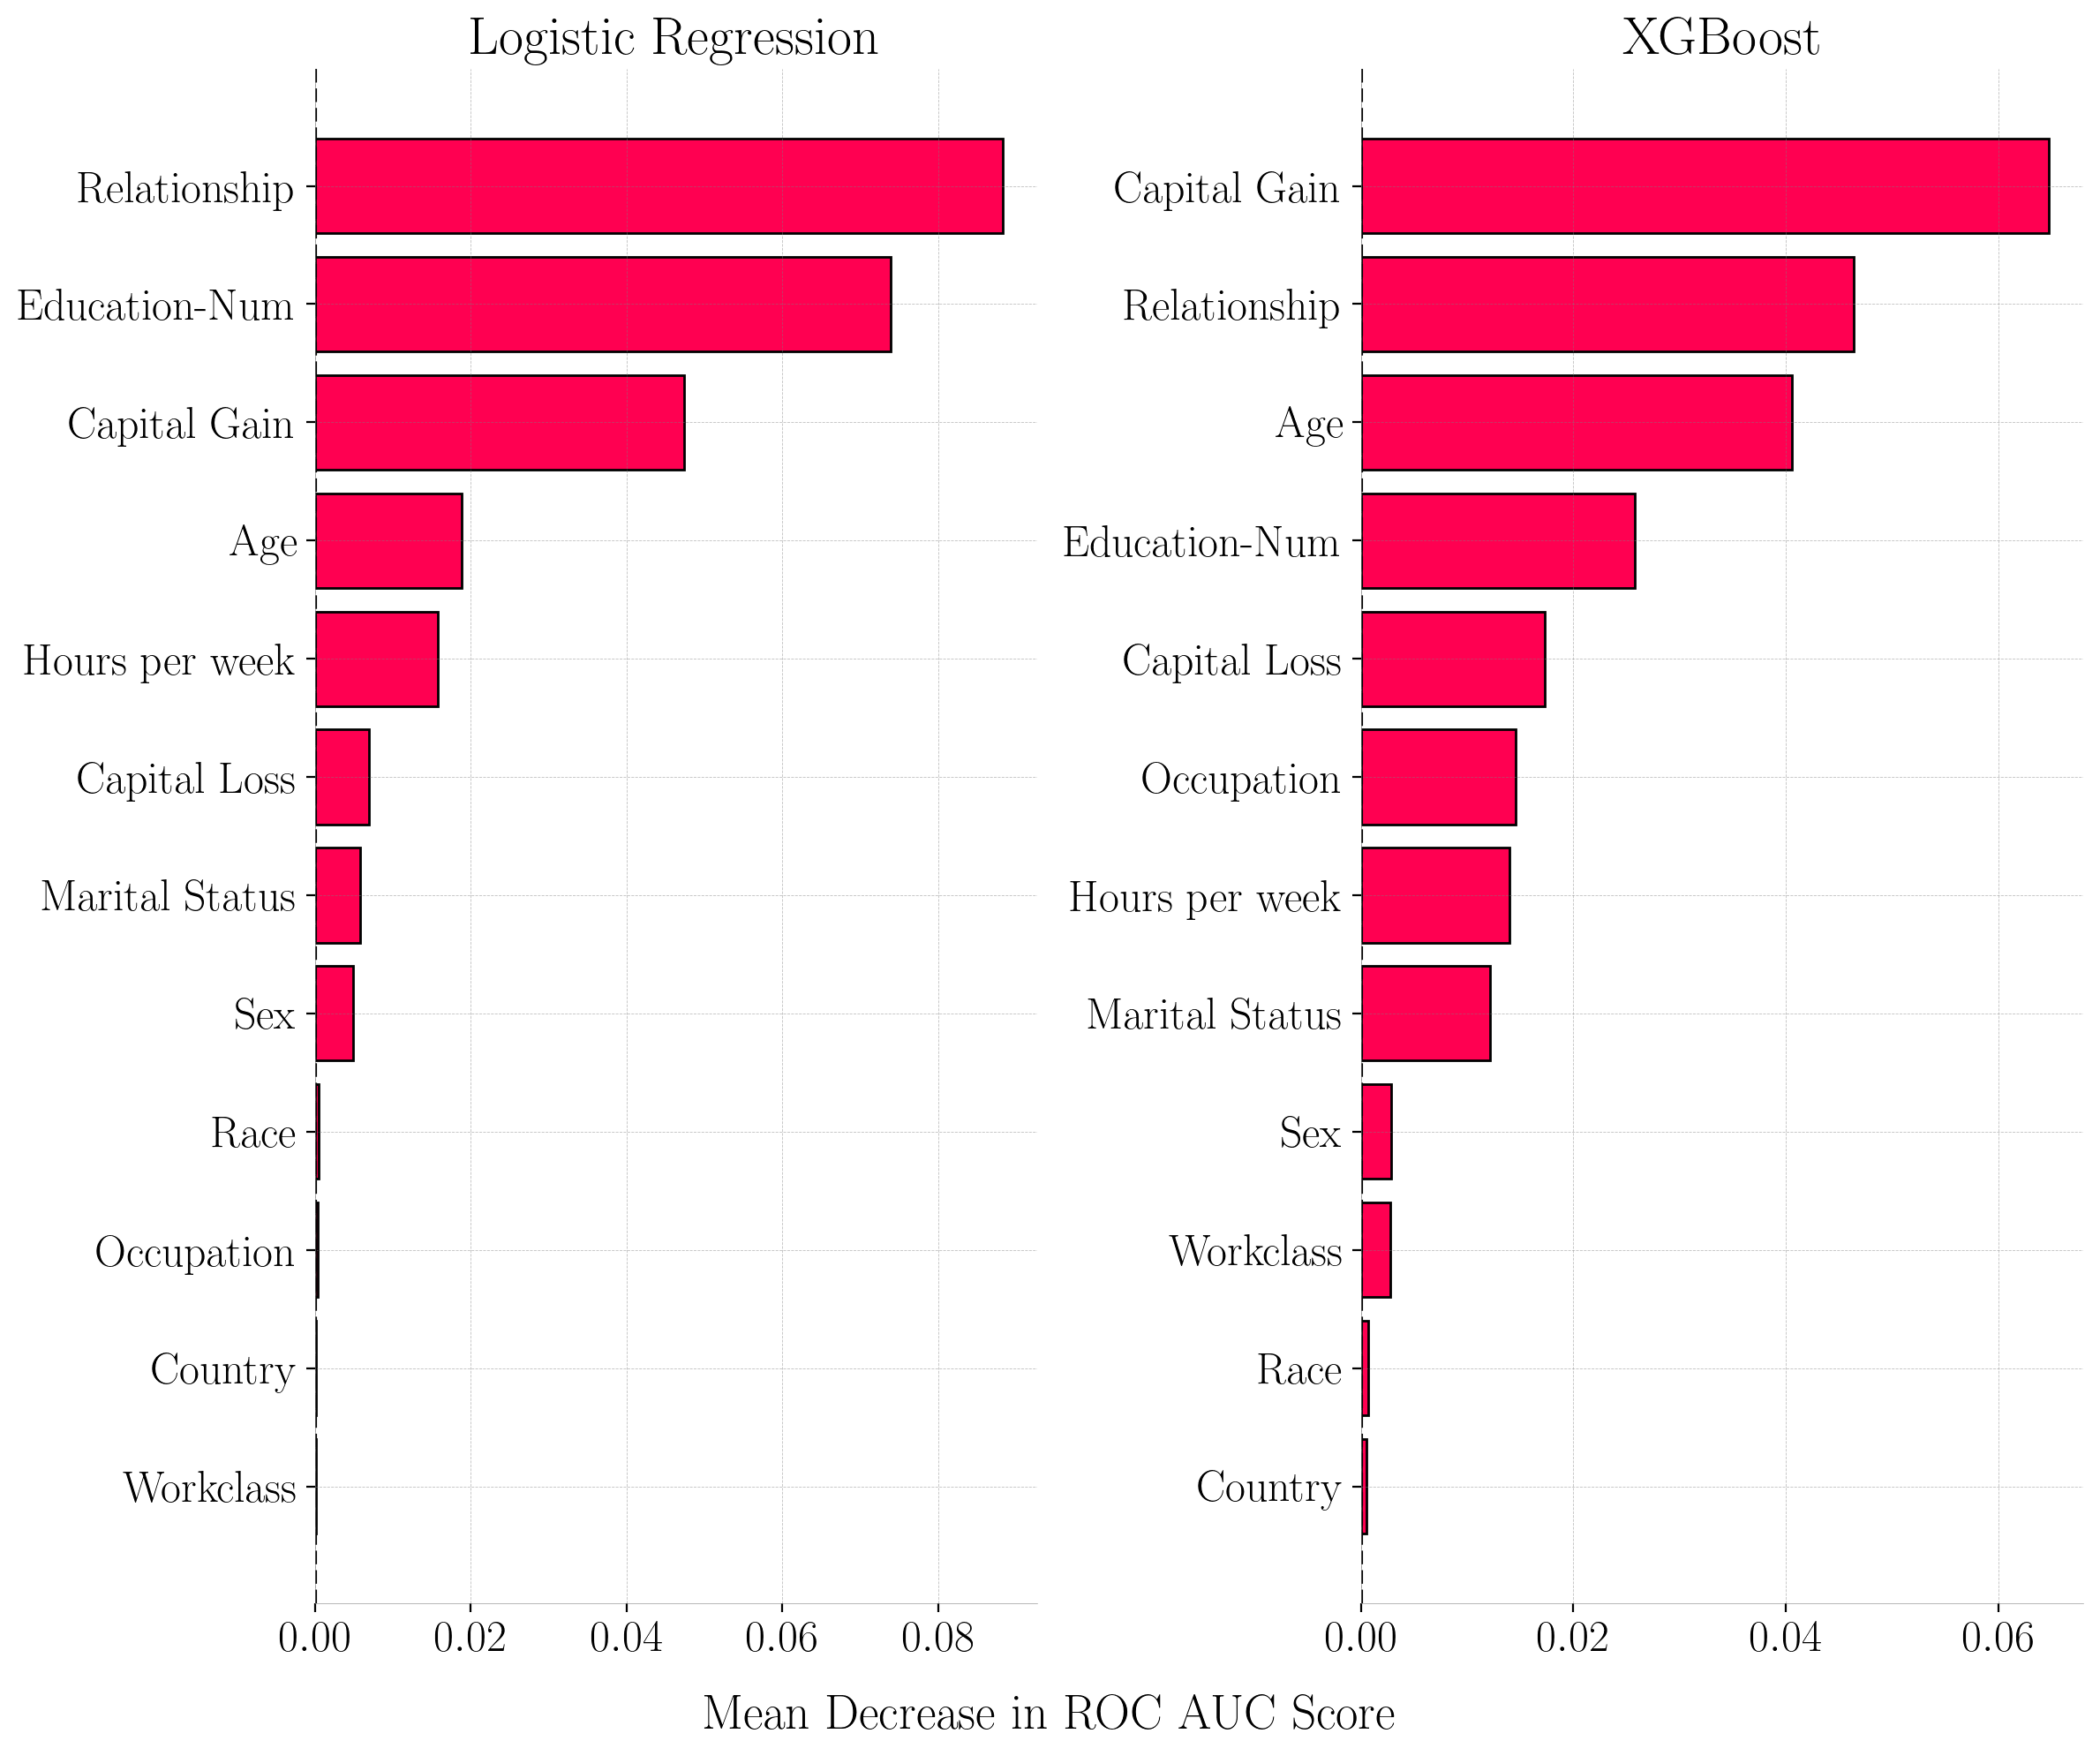

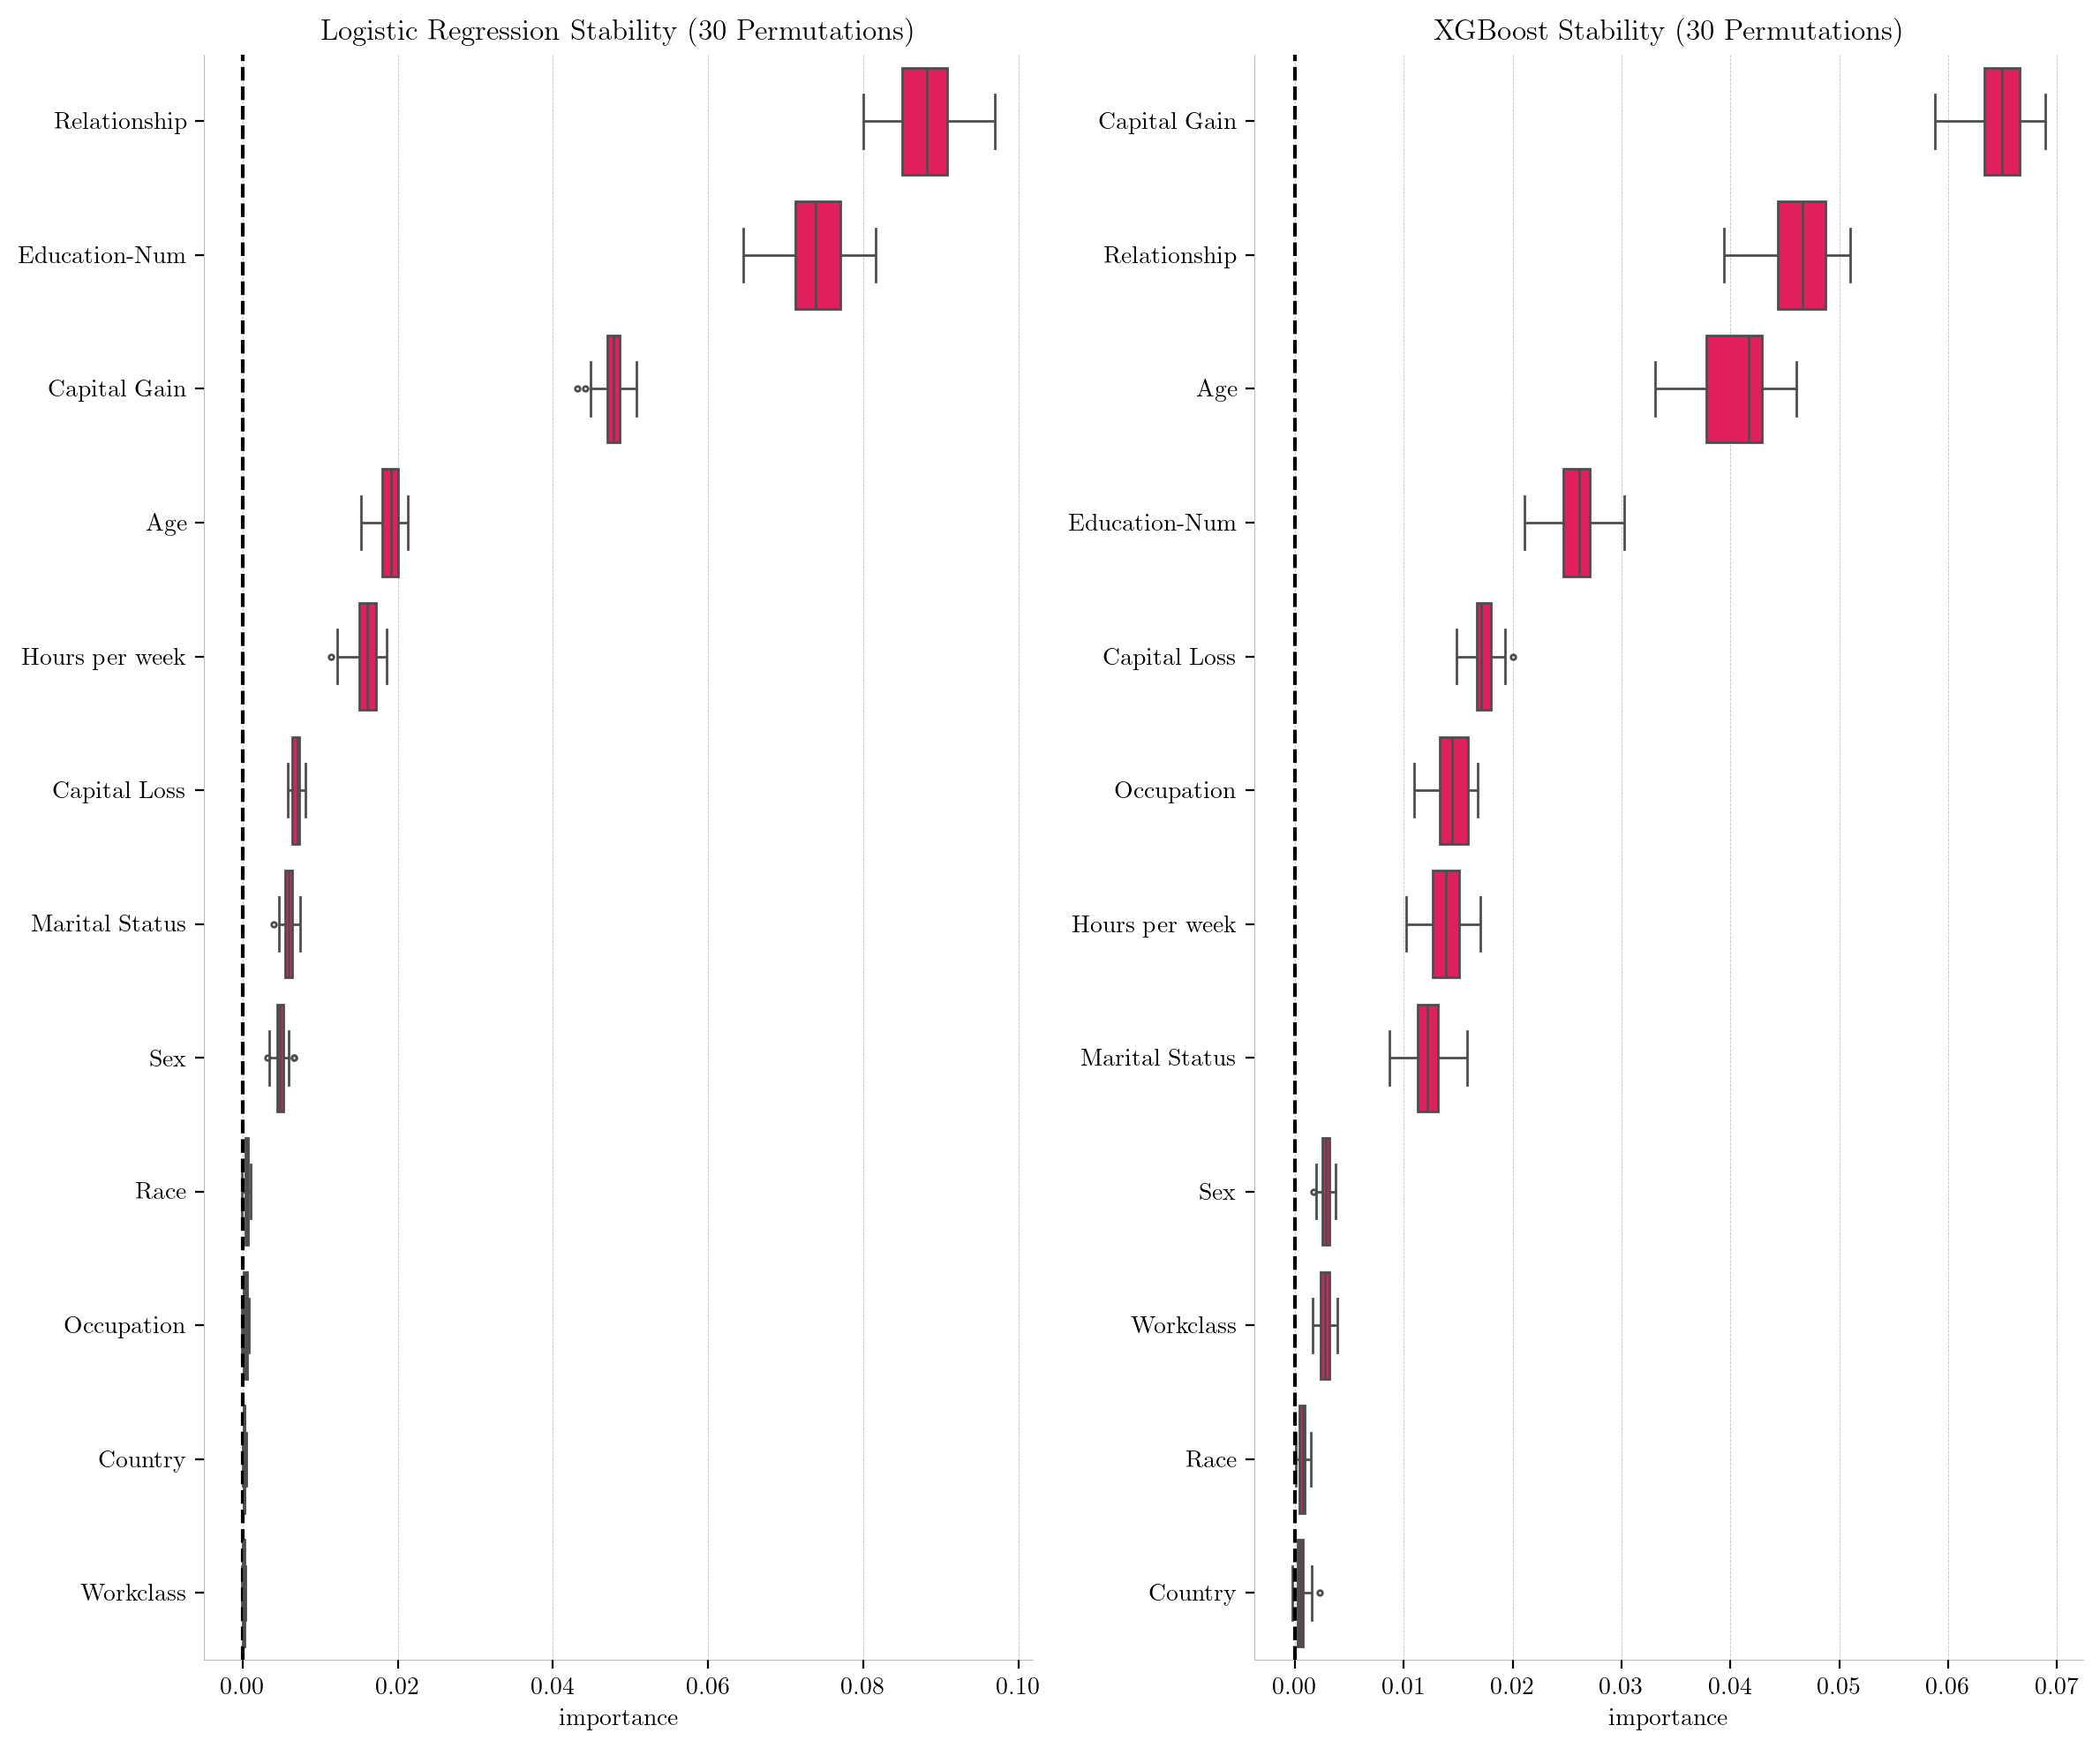

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.94      0.90      4945
        True       0.74      0.56      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513

Logistic Regression ROC AUC Score:
0.8915903381069312
XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.94      0.92      4945
        True       0.77      0.69      0.73      1568

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513

XGBoost ROC AUC Score:
0.9292712180928995

Logistic Regression — Permutation Feature Importance (ROC-AUC)
       feature  mean_roc_auc_decrease
  Relationship               0.088326
 Education-Num               0.07392

In [5]:
# PFI
X, y = load_adult_dataset(r"PATH_TO_DATASET")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

model_lr = LogisticRegression(
    max_iter=1000,
    random_state=42
)
model_lr.fit(X_train_scaled, y_train)

model_xgb = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train, y_train)

r_lr = permutation_importance(
    model_lr,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

r_xgb = permutation_importance(
    model_xgb,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

df_lr, tidy_lr, feats_lr = process_importance(r_lr, X.columns)
df_xgb, tidy_xgb, feats_xgb = process_importance(r_xgb, X.columns)

shap_red = mcolors.to_hex(shap.plots.colors.red_blue(1.0))

fig1, axes1 = plt.subplots(1, 2, figsize=(12, 10))

axes1[0].barh(
    df_lr["feature"],
    df_lr["importance_mean"],
    color=shap_red,
    edgecolor="black"
)
axes1[0].invert_yaxis()
axes1[0].set_title("Logistic Regression", fontsize=22)
#axes1[0].set_xlabel("Mean Decrease in ROC AUC Score")
axes1[0].axvline(0, color='k', linestyle='--')
axes1[0].tick_params(axis='y', labelsize=18)
axes1[0].tick_params(axis='x', labelsize=18)

axes1[1].barh(
    df_xgb["feature"],
    df_xgb["importance_mean"],
    color=shap_red,
    edgecolor="black"
)
axes1[1].invert_yaxis()
axes1[1].set_title("XGBoost", fontsize=22)
#axes1[1].set_xlabel("Mean Decrease in ROC AUC Score")
axes1[1].axvline(0, color='k', linestyle='--')
axes1[1].tick_params(axis='y', labelsize=18)
axes1[1].tick_params(axis='x', labelsize=18)

fig1.supxlabel("Mean Decrease in ROC AUC Score", fontsize=20)
plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 10))

sns.boxplot(
    data=tidy_lr,
    x="importance",
    y="feature",
    order=feats_lr,
    orient="h",
    ax=axes2[0],
    color=shap_red,
    fliersize=2
)
axes2[0].set_title("Logistic Regression Stability (30 Permutations)")
axes2[0].axvline(0, color='k', linestyle='--')
axes2[0].set_ylabel("")

sns.boxplot(
    data=tidy_xgb,
    x="importance",
    y="feature",
    order=feats_xgb,
    orient="h",
    ax=axes2[1],
    color=shap_red,
    fliersize=2
)
axes2[1].set_title("XGBoost Stability (30 Permutations)")
axes2[1].axvline(0, color='k', linestyle='--')
axes2[1].set_ylabel("")

plt.tight_layout()
plt.show()

print("Logistic Regression Classification Report:")
print(classification_report(y_test, model_lr.predict(X_test_scaled)))
print("Logistic Regression ROC AUC Score:")
print(roc_auc_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]))

print("XGBoost Classification Report:")
print(classification_report(y_test, model_xgb.predict(X_test)))
print("XGBoost ROC AUC Score:")
print(roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1]))

print_pfi_table(r_lr, X.columns, "Logistic Regression")
print_pfi_table(r_xgb, X.columns, "XGBoost")

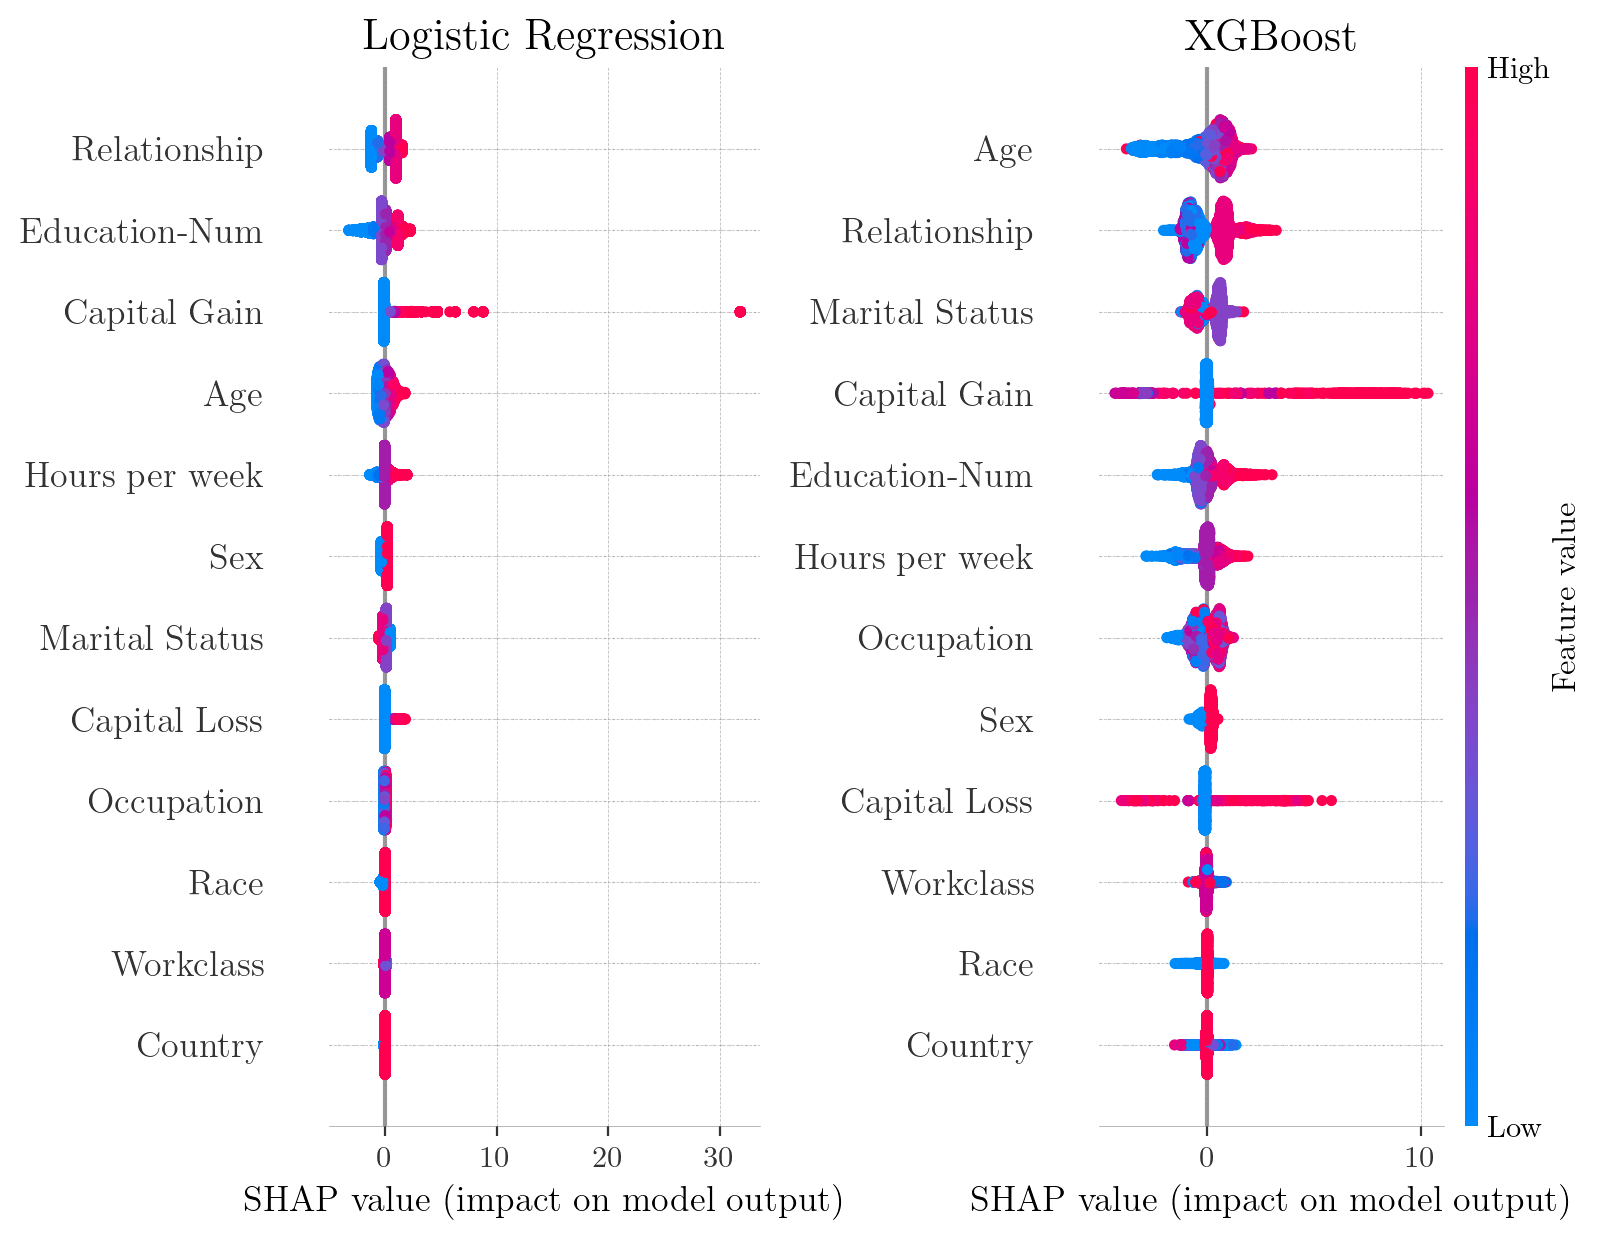


Logistic Regression — SHAP Feature Importance (mean |SHAP|)
           feature  mean_abs_shap
0     Relationship       0.917195
1    Education-Num       0.679165
2     Capital Gain       0.447602
3              Age       0.383199
4   Hours per week       0.264760
5              Sex       0.246689
6   Marital Status       0.213802
7     Capital Loss       0.093638
8       Occupation       0.057266
9             Race       0.056345
10       Workclass       0.024001
11         Country       0.014512

XGBoost — SHAP Feature Importance (mean |SHAP|)
           feature  mean_abs_shap
0              Age       0.870599
1     Relationship       0.796658
2   Marital Status       0.515516
3     Capital Gain       0.484936
4    Education-Num       0.465093
5   Hours per week       0.458493
6       Occupation       0.444062
7              Sex       0.227185
8     Capital Loss       0.222908
9        Workclass       0.090925
10            Race       0.062655
11         Country       0.060435

--- L

In [ ]:
# Full SHAP plot
shap_lr_data = load_shap("shap_results/adult_logreg.pkl")
shap_xgb_data = load_shap("shap_results/adult_xgboost.pkl")

shap_values_lr = shap_lr_data["shap_values"]
shap_values_xgb = shap_xgb_data["shap_values"]

feature_names = shap_lr_data["feature_names"]

shap_lr = shap.Explanation(
    values=shap_values_lr,
    base_values=shap_lr_data["base_values"],
    data=shap_lr_data["data"],
    feature_names=feature_names
)

shap_xgb = shap.Explanation(
    values=shap_values_xgb,
    base_values=shap_xgb_data["base_values"],
    data=shap_xgb_data["data"],
    feature_names=feature_names
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

plt.sca(axes[0])
plt.title("Logistic Regression", fontsize=16)
shap.plots.beeswarm(
    shap_lr, 
    show=False, 
    color_bar=False, 
    max_display=12
)

plt.sca(axes[1])
plt.title("XGBoost", fontsize=16)
shap.plots.beeswarm(
    shap_xgb, 
    show=False, 
    color_bar=True, 
    max_display=12
)

plt.tight_layout()
plt.show()


print_shap_importance(shap_lr, feature_names, "Logistic Regression")
print_shap_importance(shap_xgb, feature_names, "XGBoost")

print("\n--- Logistic Regression Coefficients (Loaded) ---")
if "coefficients" in shap_lr_data.get("extra_meta", {}):
    df_coeffs = shap_lr_data["extra_meta"]["coefficients"]
    print(df_coeffs[['Feature', 'Coefficient']].to_string(index=False))
else:
    print("Coefficients not found in saved file. Run compute_shap_adult.py again.")
    
print("\n--- XGBoost Gain Ranking (Loaded) ---")
if "gain" in shap_xgb_data.get("extra_meta", {}):
    df_gain = shap_xgb_data["extra_meta"]["gain"]
    print(df_gain.to_string(index=False))
else:
    print("Gain data not found in saved file. Run compute_shap_adult.py again.")

Removed 35 outlier(s) from Logistic Regression data for better visualization.


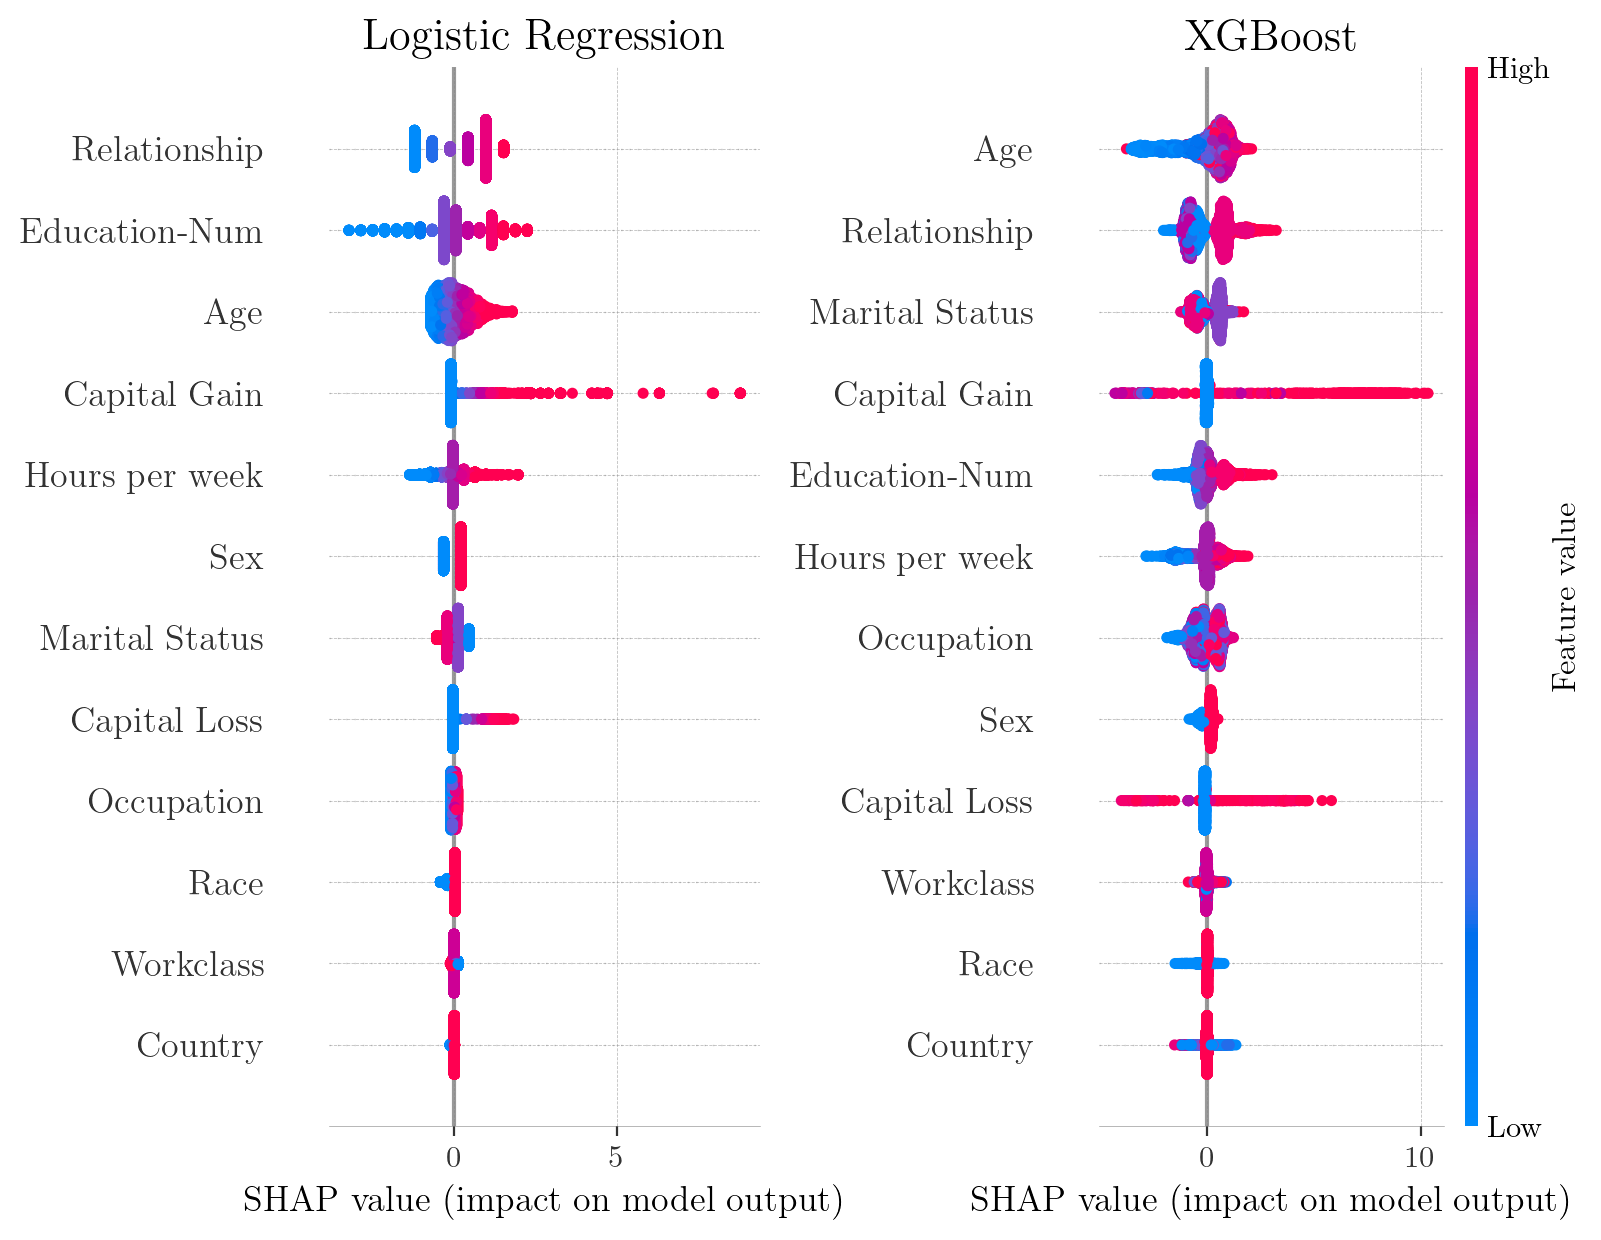


Logistic Regression — SHAP Feature Importance (mean |SHAP|)
           feature  mean_abs_shap
0     Relationship       0.917195
1    Education-Num       0.679165
2     Capital Gain       0.447602
3              Age       0.383199
4   Hours per week       0.264760
5              Sex       0.246689
6   Marital Status       0.213802
7     Capital Loss       0.093638
8       Occupation       0.057266
9             Race       0.056345
10       Workclass       0.024001
11         Country       0.014512

XGBoost — SHAP Feature Importance (mean |SHAP|)
           feature  mean_abs_shap
0              Age       0.870599
1     Relationship       0.796658
2   Marital Status       0.515516
3     Capital Gain       0.484936
4    Education-Num       0.465093
5   Hours per week       0.458493
6       Occupation       0.444062
7              Sex       0.227185
8     Capital Loss       0.222908
9        Workclass       0.090925
10            Race       0.062655
11         Country       0.060435

--- L

In [ ]:
# Removed "Capital Gain" outlier and re-plot
shap_lr_data = load_shap("shap_results/adult_logreg.pkl")
shap_xgb_data = load_shap("shap_results/adult_xgboost.pkl")

shap_values_lr = shap_lr_data["shap_values"]
shap_values_xgb = shap_xgb_data["shap_values"]
feature_names = shap_lr_data["feature_names"]

shap_lr = shap.Explanation(
    values=shap_values_lr,
    base_values=shap_lr_data["base_values"],
    data=shap_lr_data["data"],
    feature_names=feature_names
)

shap_xgb = shap.Explanation(
    values=shap_values_xgb,
    base_values=shap_xgb_data["base_values"],
    data=shap_xgb_data["data"],
    feature_names=feature_names
)

if "Capital Gain" in feature_names:
    cap_gain_idx = feature_names.index("Capital Gain")
    
    threshold = np.percentile(np.abs(shap_lr.values[:, cap_gain_idx]), 99.9)
    
    mask = np.abs(shap_lr.values[:, cap_gain_idx]) < threshold
    
    shap_lr_filtered = shap_lr[mask]
    
    print(f"Removed {len(shap_lr) - len(shap_lr_filtered)} outlier(s) from Logistic Regression data for better visualization.")
else:
    shap_lr_filtered = shap_lr
    print("Feature 'Capital Gain' not found; no filtering applied.")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

plt.sca(axes[0])
plt.title("Logistic Regression", fontsize=16)
shap.plots.beeswarm(
    shap_lr_filtered, 
    show=False, 
    color_bar=False, 
    max_display=12
)

plt.sca(axes[1])
plt.title("XGBoost", fontsize=16)
shap.plots.beeswarm(
    shap_xgb, 
    show=False, 
    color_bar=True, 
    max_display=12
)

plt.tight_layout()
plt.show()

print_shap_importance(shap_lr, feature_names, "Logistic Regression")
print_shap_importance(shap_xgb, feature_names, "XGBoost")

print("\n--- Logistic Regression Coefficients (Loaded) ---")
if "coefficients" in shap_lr_data.get("extra_meta", {}):
    df_coeffs = shap_lr_data["extra_meta"]["coefficients"]
    print(df_coeffs[['Feature', 'Coefficient']].to_string(index=False))
else:
    print("Coefficients not found in saved file. Run compute_shap_adult.py again.")

print("\n--- XGBoost Gain Ranking (Loaded) ---")
if "gain" in shap_xgb_data.get("extra_meta", {}):
    df_gain = shap_xgb_data["extra_meta"]["gain"]
    print(df_gain.to_string(index=False))
else:
    print("Gain data not found in saved file. Run compute_shap_adult.py again.")

Loading and preprocessing Adult dataset...
Training baseline XGBoost model...
Baseline ROC AUC: 0.9293
Calculating feature rankings...

Generating Iterative Feature Selection Scores...

################################################################################
SCENARIO: ADD BEST
################################################################################

--- Method: SHAP ---
 Step  Feature_Added  ROC_AUC
    1            Age 0.708135
    2   Relationship 0.821435
    3 Marital Status 0.822753
    4   Capital Gain 0.872346
    5  Education-Num 0.906139
    6 Hours per week 0.910228
    7     Occupation 0.916486
    8            Sex 0.917458
    9   Capital Loss 0.927585
   10      Workclass 0.929237
   11           Race 0.929510
   12        Country 0.929213
------------------------------------------------------------

--- Method: PFI ---
 Step  Feature_Added  ROC_AUC
    1   Capital Gain 0.626112
    2   Relationship 0.843284
    3            Age 0.871529
    4  Education-Nu

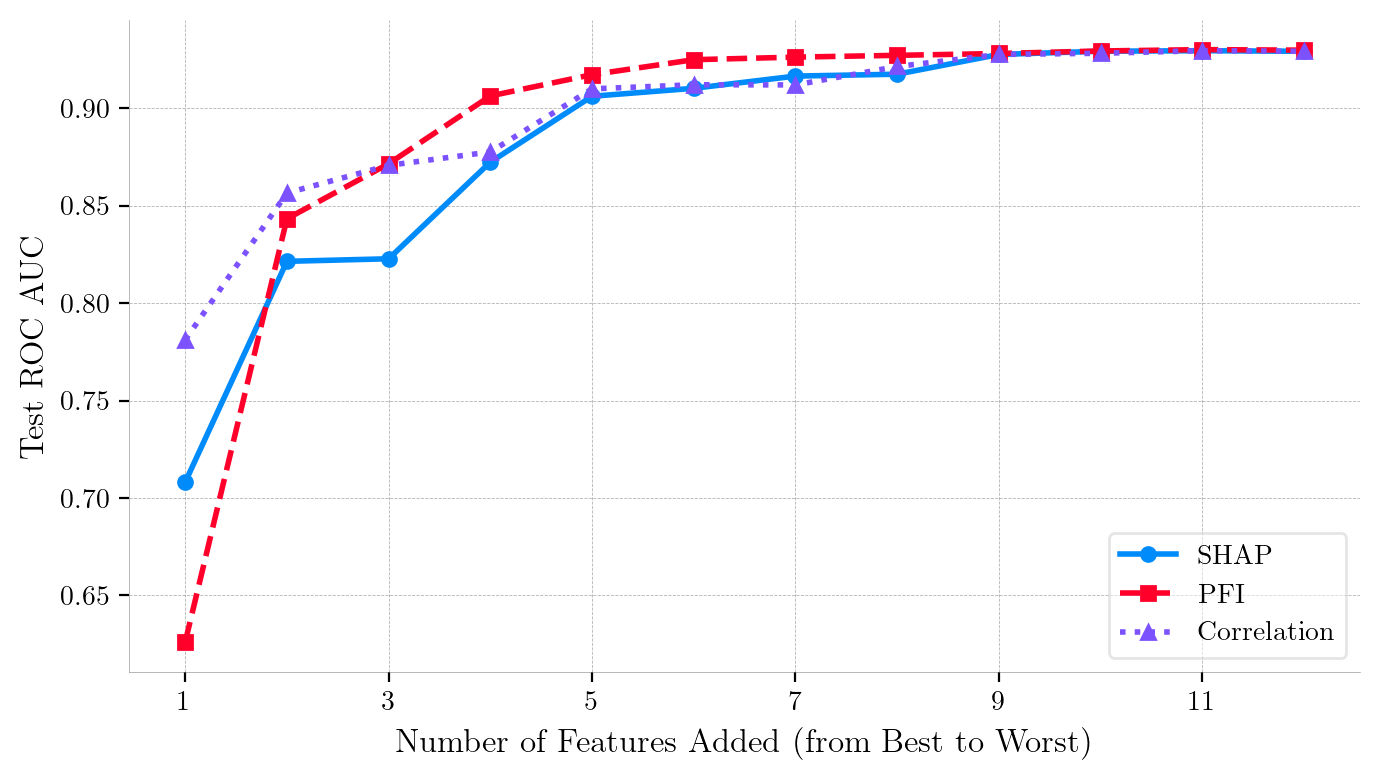

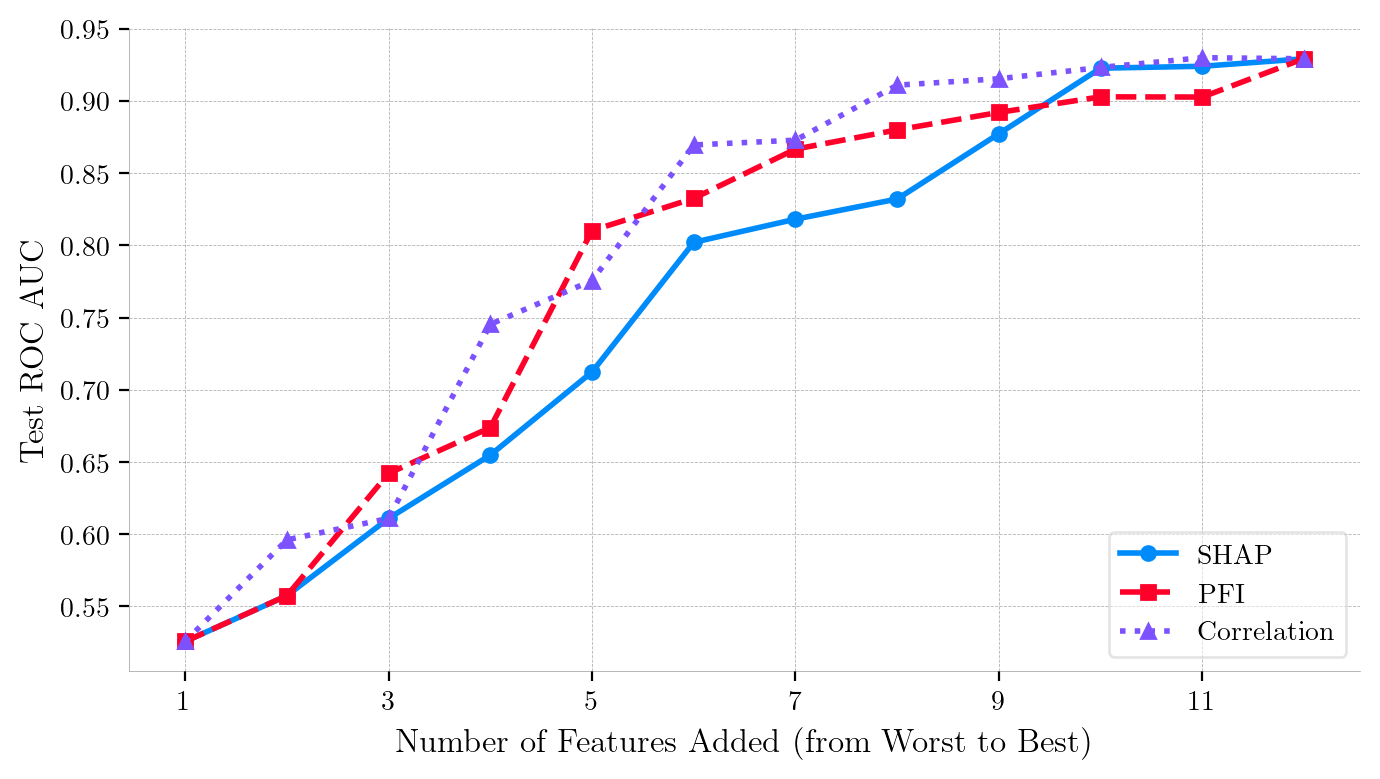

Done.


In [ ]:
X, y = load_adult_dataset(r"PATH_TO_DATA_FOLDER")
X = pd.DataFrame(X, columns=X.columns)
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols = X.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

baseline_model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_scaled, y_train)

baseline_pred = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, baseline_pred):.4f}")
print("=" * 70)

shap_ranking = [
    "Age", "Relationship", "Marital Status", "Capital Gain", "Education-Num",
    "Hours per week", "Occupation", "Sex", "Capital Loss", "Workclass",
    "Race", "Country"
]

pfi = permutation_importance(
    baseline_model,
    X_test_scaled,
    y_test,
    n_repeats=15,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

pfi_ranking = [
    f for _, f in sorted(zip(pfi.importances_mean, feature_names), reverse=True)
]

train_corr = X_train_scaled[numeric_cols].copy()
train_corr["target"] = y_train

corr_values = (
    train_corr.corr()["target"]
    .abs()
    .drop("target")
    .sort_values(ascending=False)
)
corr_ranking = corr_values.index.tolist() + [
    f for f in feature_names if f not in corr_values.index
]

rankings = {
    "SHAP": shap_ranking,
    "PFI": pfi_ranking,
    "Correlation": corr_ranking
}

scenarios = ["add_best", "add_worst"]

for mode in scenarios:
    print("#" * 80)
    print(f"SCENARIO: {mode.upper().replace('_', ' ')}")
    print("#" * 80)

    for method, ranking in rankings.items():
        print(f"\n--- Method: {method} ---")
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        print(df.to_string(index=False))
        print("-" * 60)

print("Tables generated.")
print("=" * 80)

colors = {
    "SHAP": "#008BFB", 
    "PFI": "#FF002B", 
    "Correlation": "#7C52FF"
}

markers = {
    "SHAP": "o", 
    "PFI": "s", 
    "Correlation": "^"
}

styles = {
    "SHAP": "-", 
    "PFI": "--", 
    "Correlation": ":"
}

plot_scenarios = [
    ("add_best", "Number of Features Added (from Best to Worst)"),
    ("add_worst", "Number of Features Added (from Worst to Best)")
]

print("Generating plots...")

for mode, xlabel in plot_scenarios:
    plt.figure(figsize=(7, 4))

    for method, ranking in rankings.items():
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        xs, ys = trajectory_to_xy(df)

        plt.plot(
            xs, ys,
            label=method,
            color=colors[method],
            marker=markers[method],
            linestyle=styles[method],
            linewidth=2,
            markersize=5
        )

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Test ROC AUC", fontsize=12)
    plt.xticks(range(1, len(feature_names) + 1, 2))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

print("Done.")

In [ ]:
# Statistical Analysis
X, y = load_adult_dataset(r"PATH_TO_DATA_FOLDER")

df = X.copy()
df['target'] = y

zero_gain = (df['Capital Gain'] == 0).mean()
print(f"1. Capital Gain Sparsity:")
print(f"   - Percentage of rows with Capital Gain = 0: {zero_gain:.2%}")
print(f"   - Mean Income (>50k) when Gain = 0: {df[df['Capital Gain'] == 0]['target'].mean():.2%}")
print(f"   - Mean Income (>50k) when Gain > 0: {df[df['Capital Gain'] > 0]['target'].mean():.2%}")
print("-" * 30)

print("2. Sex Analysis:")
print(f"   - Unique values in 'Sex': {df['Sex'].unique()}")
male_income = df[df['Sex'] == 1]['target'].mean()
female_income = df[df['Sex'] == 0]['target'].mean()
print(f"   - Probability of High Income (Male/1): {male_income:.2%}")
print(f"   - Probability of High Income (Female/0): {female_income:.2%}")
print(f"   - Ratio (Male/Female): {male_income/female_income:.2f}x")
print("-" * 30)

print("3. Relationship Analysis:")
rel_stats = df.groupby('Relationship')['target'].agg(['mean', 'count'])
print(rel_stats)
print("-" * 30)

print("4. Age Analysis (Income by Decade):")
df['Age_Decade'] = (df['Age'] // 10) * 10
age_stats = df.groupby('Age_Decade')['target'].mean()
print(age_stats)

=== ADULT DATASET DEEP DIVE ===

1. Capital Gain Sparsity:
   - Percentage of rows with Capital Gain = 0: 91.67%
   - Mean Income (>50k) when Gain = 0: 20.65%
   - Mean Income (>50k) when Gain > 0: 61.84%
------------------------------
2. Sex Analysis:
   - Unique values in 'Sex': [1 0]
   - Probability of High Income (Male/1): 30.57%
   - Probability of High Income (Female/0): 10.95%
   - Ratio (Male/Female): 2.79x
------------------------------
3. Relationship Analysis:
                  mean  count
Relationship                 
0             0.103070   8305
1             0.063262   3446
2             0.037717    981
3             0.013220   5068
4             0.448571  13193
5             0.475128   1568
------------------------------
4. Age Analysis (Income by Decade):
Age_Decade
10.0    0.001207
20.0    0.063198
30.0    0.268083
40.0    0.371010
50.0    0.386374
60.0    0.267494
70.0    0.190945
80.0    0.102564
90.0    0.186047
Name: Income_High, dtype: float64


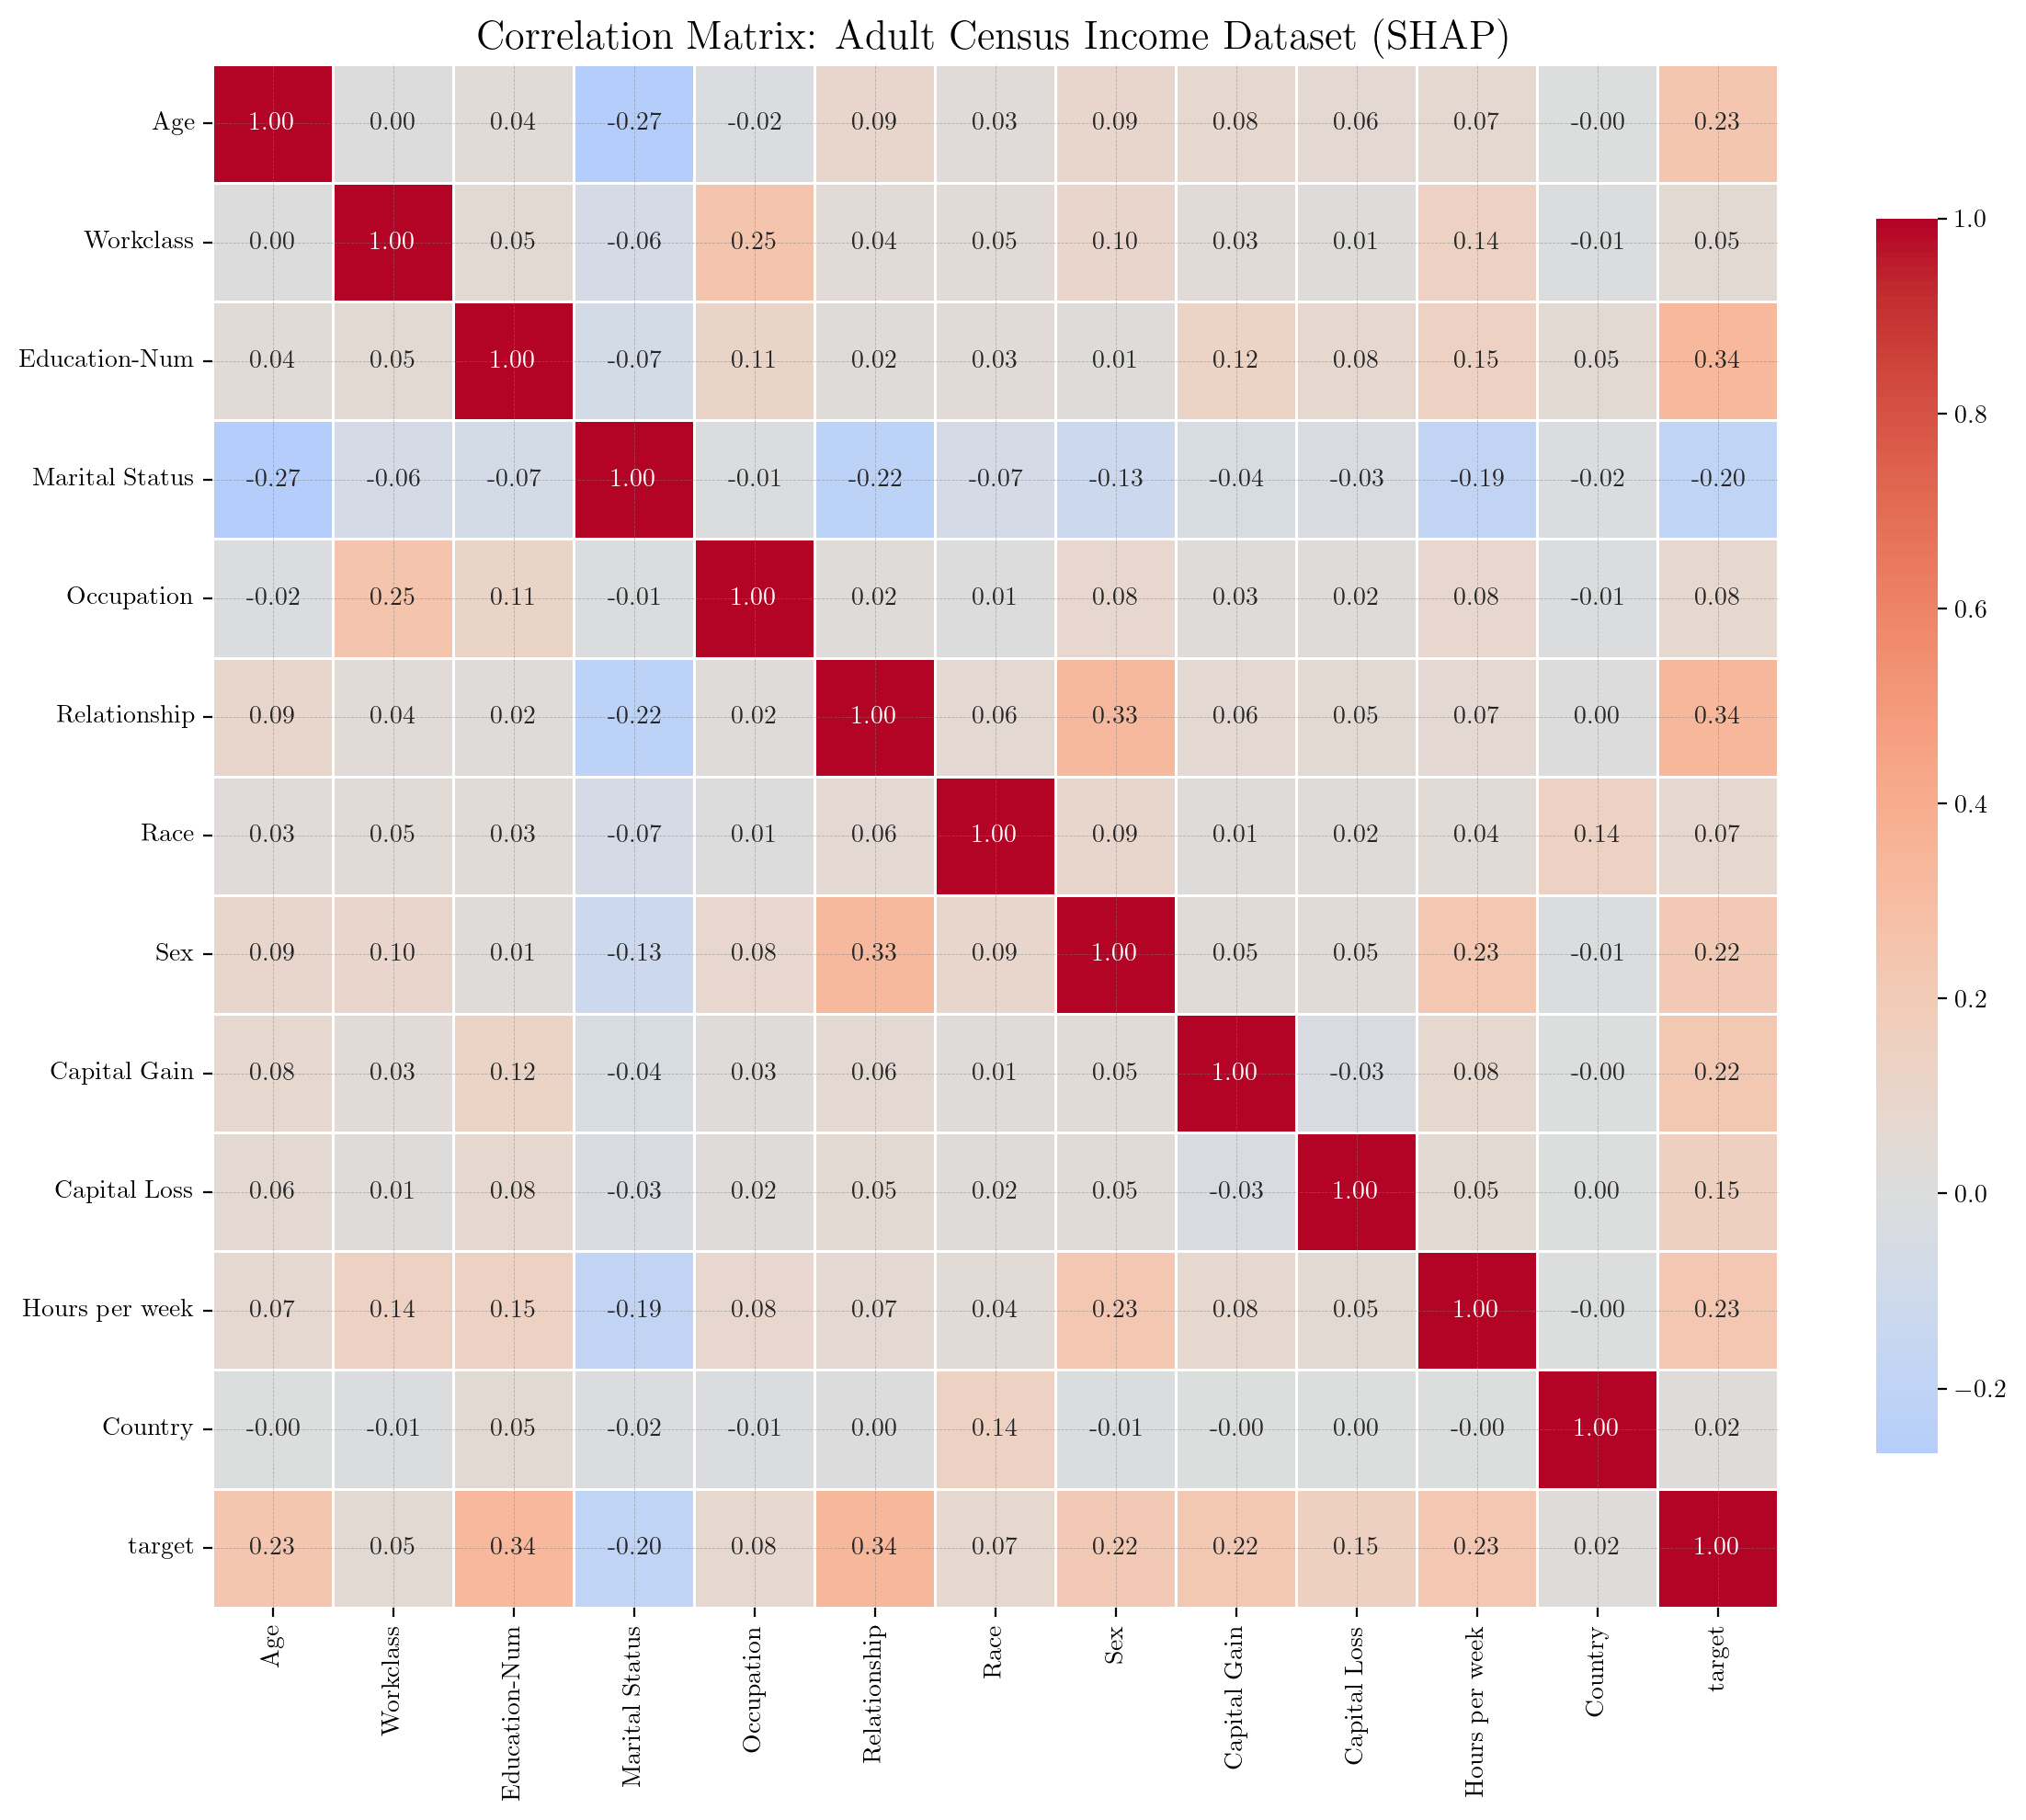

target
0    24720
1     7841
Name: count, dtype: int64


In [ ]:
X, y = load_adult_dataset(r"PATH_TO_DATA_FOLDER")

df = X.copy()
df['target'] = y.astype(int)

corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,       
    fmt=".2f",        
    cmap='coolwarm',  
    center=0,         
    linewidths=0.5,   
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix: Adult Census Income Dataset (SHAP)', fontsize=16)
plt.tight_layout()
plt.show()

print(df['target'].value_counts())

Encoding categorical features...
Computing NMI matrix...


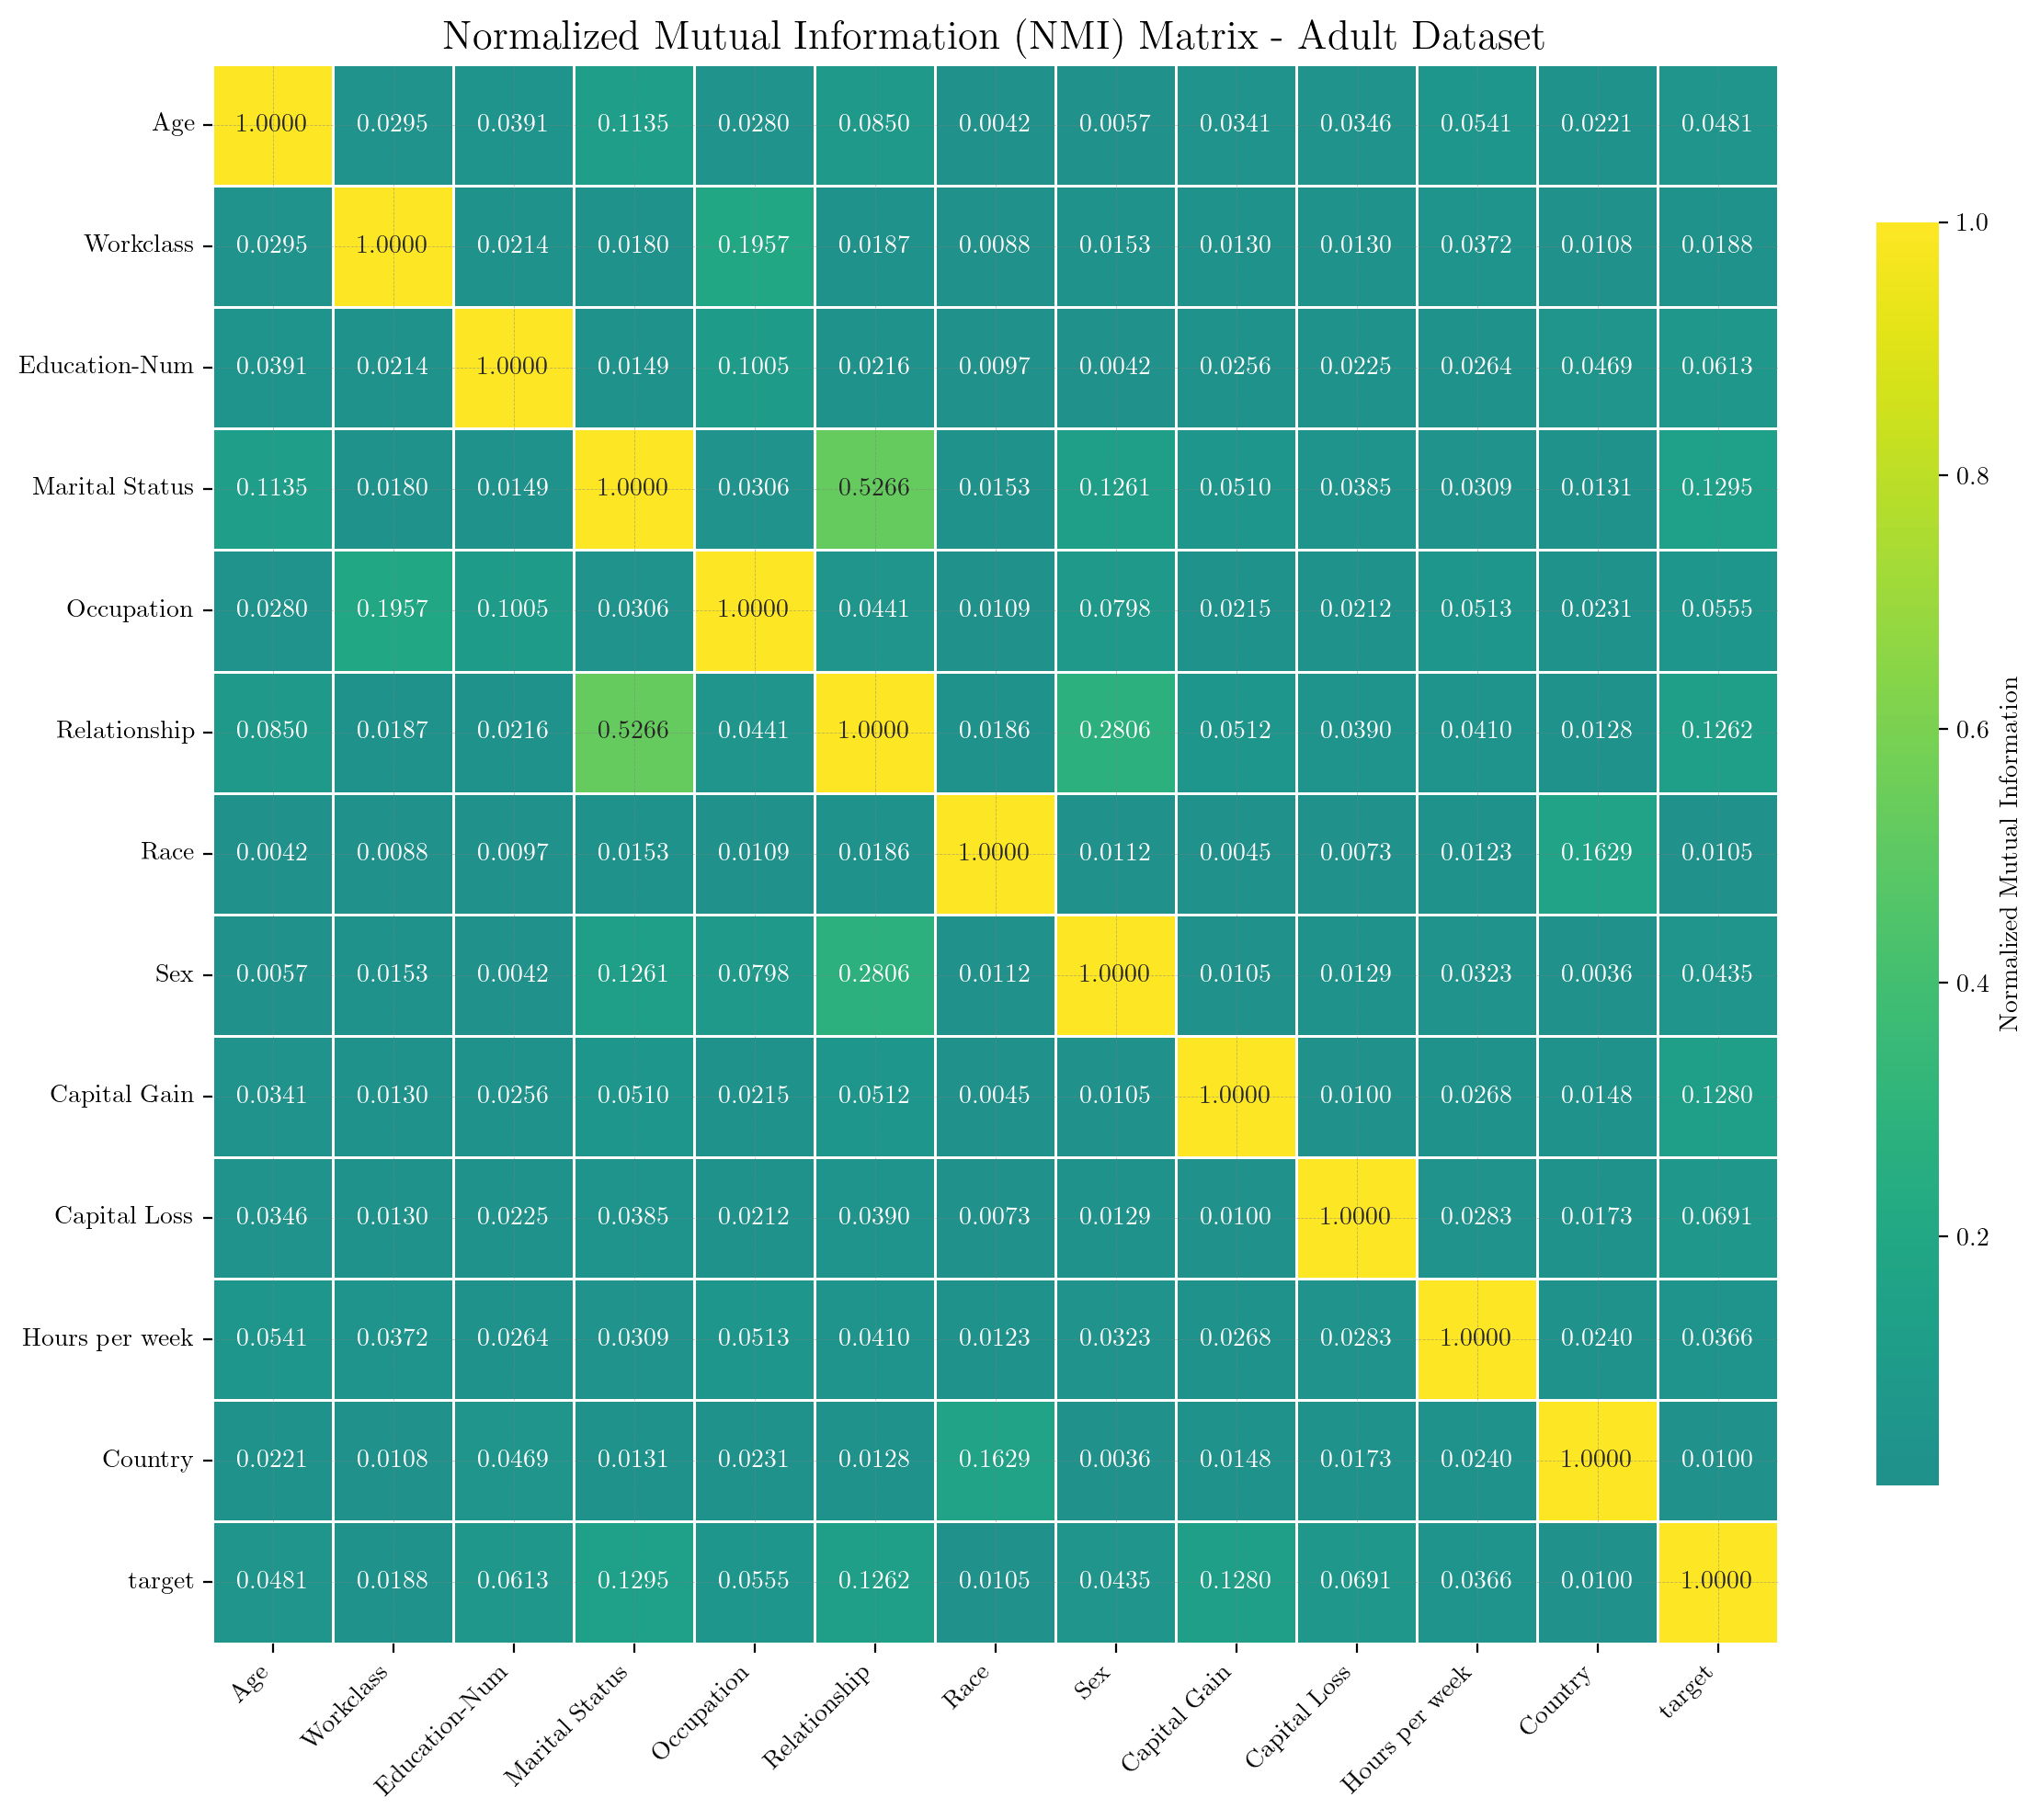

In [ ]:
X, y = load_adult_dataset(r"PATH_TO_DATA_FOLDER")
df = pd.DataFrame(X, columns=X.columns)
df['target'] = y

print("Computing NMI matrix...")
columns = df.columns
n_cols = len(columns)
nmi_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), index=columns, columns=columns)

for i in range(n_cols):
    for j in range(i, n_cols):
        col1 = columns[i]
        col2 = columns[j]
        
        val = normalized_mutual_information(df[col1].values, df[col2].values)
        
        nmi_matrix.loc[col1, col2] = val
        nmi_matrix.loc[col2, col1] = val

plt.figure(figsize=(12, 10))
sns.heatmap(
    nmi_matrix, 
    annot=True, 
    fmt=".4f", 
    cmap='viridis', 
    center=0, 
    linewidths=0.5,
    cbar_kws={"shrink": .8, "label": "Normalized Mutual Information"}
)

plt.title('Normalized Mutual Information (NMI) Matrix - Adult Dataset', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
result = nmi_matrix["target"].sort_values(ascending=False)[1:]
print(result.to_string())

Marital Status    0.129531
Capital Gain      0.128050
Relationship      0.126246
Capital Loss      0.069117
Education-Num     0.061255
Occupation        0.055524
Age               0.048095
Sex               0.043527
Hours per week    0.036645
Workclass         0.018830
Race              0.010504
Country           0.010030
